In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [40]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [3]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

/home/yulia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the data

In [4]:
main_dir = '/home/yulia/W266-Final-Project/'

In [5]:
data_path = main_dir+'data/raw/hein-daily'

In [6]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches

File speeches_098.txt has 252071246 characters
and 280289 speeches

Speeches list has 563688 speeches

File speeches_099.txt has 265326480 characters
and 281528 speeches

Speeches list has 845216 speeches

File speeches_100.txt has 270610780 characters
and 276162 speeches

Speeches list has 1121378 speeches

File speeches_101.txt has 261004871 characters
and 251217 speeches

Speeches list has 1372595 speeches

File speeches_102.txt has 271650630 characters
and 243092 speeches

Speeches list has 1615687 speeches

File speeches_103.txt has 249908822 characters
and 235974 speeches

Speeches list has 1851661 speeches

File speeches_104.txt has 280355367 characters
and 274985 speeches

Speeches list has 2126646 speeches

File speeches_105.txt has 235226903 characters
and 209267 speeches

Speeches list has 2335913 speeches

File speeches_106.txt has 243801385 characters
and 209648 speeches

In [7]:
len(all_speech_ids), len(all_speeches)

(3866201, 3866201)

## Create target labels

In [9]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data(main_dir+'data/QA/full_descr.txt')
print("\nIt took {:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
37617 keys had duplicates and deleted
The dictionary has 2808050 keys

Random congressperson: 1090182100
date 20061114
char_count 278
word_count 49
speakerid 109112991.0
Party R
Congress 109
Chamber S
State TN
Ethnicity W
Age 54.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. FRIST
Full Name FRIST, WILLIAM
match exact
check 1

It took 34.7 seconds to create the dictionary


In [10]:
# check if sampling worked
len(list(descr.keys()))/2914464

0.9634876258550458

In [12]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(3866201, 3866201, 3866201, 3866201, 3866201, 3866201)

### Data QA

In [13]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,1058151
1,0,2579578
2,1,228472


Target group number of speeches by party:
A: 	 0
D: 	 165834
I: 	 0
N: 	 0
NA: 	 -1058151
P: 	 0
R: 	 62638

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,1058151
1,0,2566825
2,1,241225


Target group number of speeches by party:
A: 	 21
D: 	 213500
I: 	 64
N: 	 334
NA: 	 -1058151
P: 	 53
R: 	 27253

 Age
Overall speech counts:


,Category,Count
0,-1,1058151
1,0,1836698
2,1,971352


Target group number of speeches by party:
A: 	 21
D: 	 482630
I: 	 360
N: 	 334
NA: 	 -1058151
P: 	 53
R: 	 487954


In [14]:
reload(explore_data)
explore_data.random_speech(all_speeches, all_speech_ids, ethnicity, descr)

Speaker information
date 19851203
char_count 2009
word_count 318
speakerid 99113770.0
Party D
Congress 99
Chamber H
State CA
Ethnicity AAPIA
Age 45.0
Age_lt_med 1.0
NonWhite 1.0
Female 0.0
speaker Mr. MATSUI
Full Name MATSUI, ROBERT
match fuzzy
check 1

Mr. Speaker. I would like to call to the attention of the U.S. House of Representatives a man whose life has been one of accomplishment and good will. On November 30. 1985. Dr. Akio Hayashi will be honored by the Sacramento Senator Lions Club on the occasion of his retirement from that fine organization. At a youthful 81 years of age. Dr. Hayashi has fulfilled his dream of being an extraordinarily productive and versatile individual. Graduating from the University of California at Berkeley College of Dentistry in 1932. Dr. Hayashi has contributed to his community with an uncommon generosity. Dr. Hayashis many posts have included membership in Omicron Kappa Upsilon Honorary Dental Society. district governor of district 4C5 of the Lions C

# Ethnicity Model

## Split into train, validate, test

In [15]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, ethnicity, descr)

Training split: 94260 ones and 94260 zeroes
Training speech list size: 188520
Training target list size: 188520
Validation split: 31420 ones and 31420 zeroes
Validation speech list size: 62840
Validation target list size: 62840
Test split: 31420 ones and 31420 zeroes
Test speech list size: 62840
Test target list size: 62840


In [16]:
sum(train_target), sum(val_target), sum(test_target)

(94260, 31420, 31420)

In [17]:
# number of speeches under 30 words
sum(np.array(ethnicity)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

84125

In [18]:
# random speech from a train set where target=1
explore_data.random_speech(train, train_ids, train_target, descr)

Speaker information
date 20120801
char_count 955
word_count 158
speakerid 112116580.0
Party D
Congress 112
Chamber H
State CA
Ethnicity H
Age 65.0
Age_lt_med 0.0
NonWhite 1.0
Female 0.0
speaker Mr. BACA
Full Name BACA, JOE
match exact
check 1

Madam Speaker. this Monday. Colton Joint Unified School District held a dedication ceremony for the new Joe Baca Middle School in Bloomington. California. Next week. 800 students from the surrounding communities in Bloomington and Rialto will begin to attend classes there. I am truly humbled to receive this distinguished honor. and I thank the Colton Joint Unified School District. I want to especially recognize Superintendent Jerry Almendarez. all of the school board members of the Colton Joint Unified School District. Ignacio Gomez. whose beautiful artwork will be displayed at the school. and Congressman GARY MILLER for his bipartisan support. Growing up the youngest of 15 children in a poor household. I never would imagine that one day I would 

## EDA on train data

Source: https://developers.google.com/machine-learning/guides/text-classification/step-2

### Check median number of words per sample in train/val/test

In [19]:
explore_data.get_num_words_per_sample(train)

238.0

In [20]:
explore_data.get_num_words_per_sample(val)

238.0

In [21]:
explore_data.get_num_words_per_sample(test)

238.0

Speech length percentiles
    0     10    20     30     40     50     60     70     80     90       100
0  31.0  45.0  74.0  126.0  181.0  238.0  312.0  402.0  540.0  805.0  22613.0


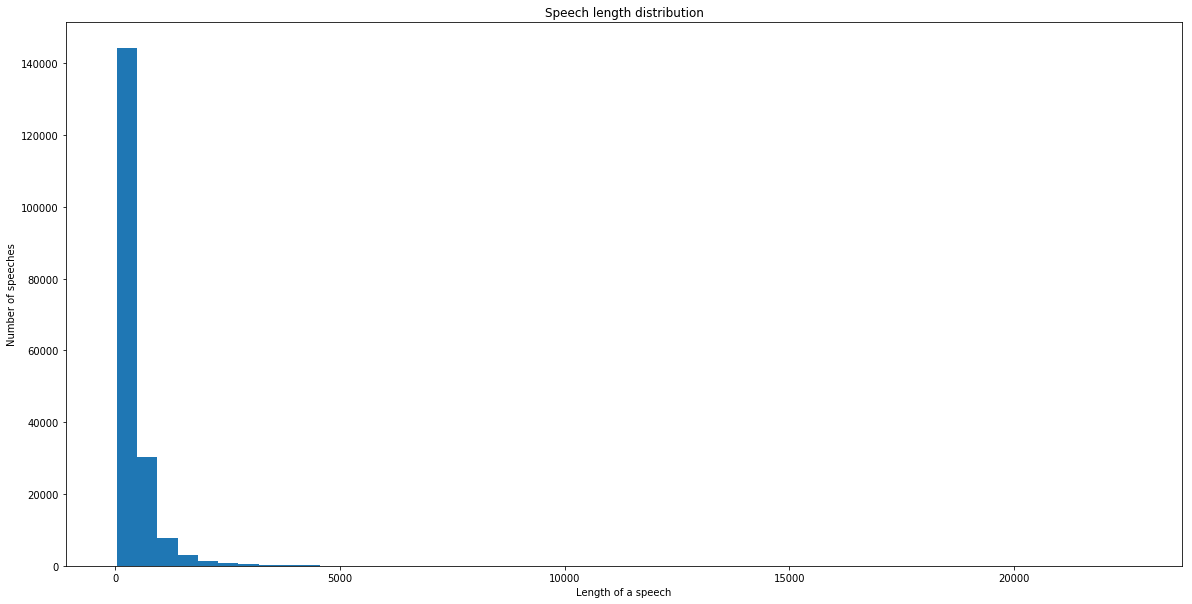

In [22]:
explore_data.plot_sample_length_distribution(train)

In [23]:
train_party = [descr[train_ids[i]]['Party'] for i in range(len(train_ids))]

In [25]:
explore_data.get_counts_by_category(train_target, train_party)

A: 	 12
D: 	 83580
I: 	 32
N: 	 158
P: 	 24
R: 	 10454


### Most popular ngrams (training only) - exluding stop words

In [26]:
# take a sample to avoid running out of memory
train_sample = random.sample(train, int(len(train)*0.2))
len(train_sample)

37704

['we', 'it', 'have', 'are', 'as', 'not', 'be', 'with', 'our', 'will', 'from', 'by', 'has', 'they', 'was', 'would', 'my', 'an', 'their', 'at', 'who', 'bill', 'but', 'all', 'he', 'or', 'his', 'do', 'which', 'people', 'been', 'president', 'there', 'speaker', 'what', 'you', 'these', 'about', 'so', 'time', 'if', 'more', 'one', 'can', 'years', 'those', 'states', 'no', 'us', 'amendment']


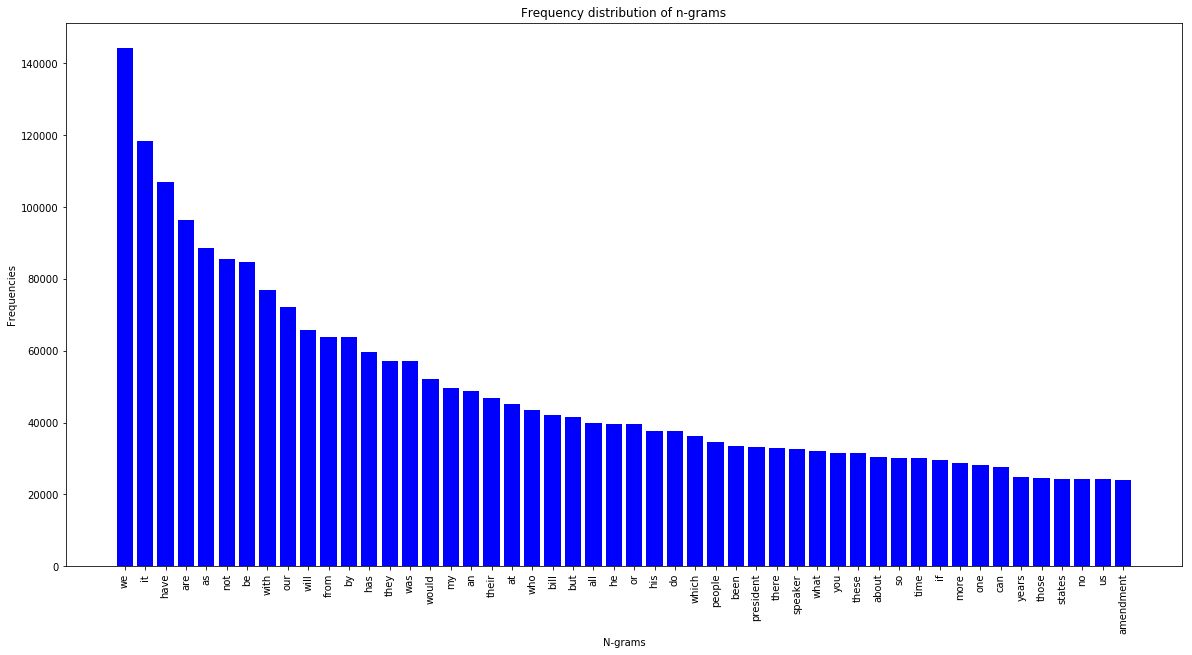

In [27]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(1,1))

['in the', 'to the', 'it is', 'and the', 'on the', 'for the', 'mr speaker', 'that the', 'to be', 'we have', 'we are', 'that is', 'that we', 'with the', 'by the', 'of this', 'united states', 'the united', 'in this', 'mr president', 'at the', 'will be', 'is the', 'this bill', 'going to', 'from the', 'has been', 'this is', 'want to', 'of our', 'my colleagues', 'is not', 'the gentleman', 'have been', 'the senate', 'do not', 'the house', 'the bill', 'there is', 'to do', 'they are', 'one of', 'as the', 'mr chairman', 'the american', 'would be', 'all of', 'gentleman from', 'to make', 'the president']


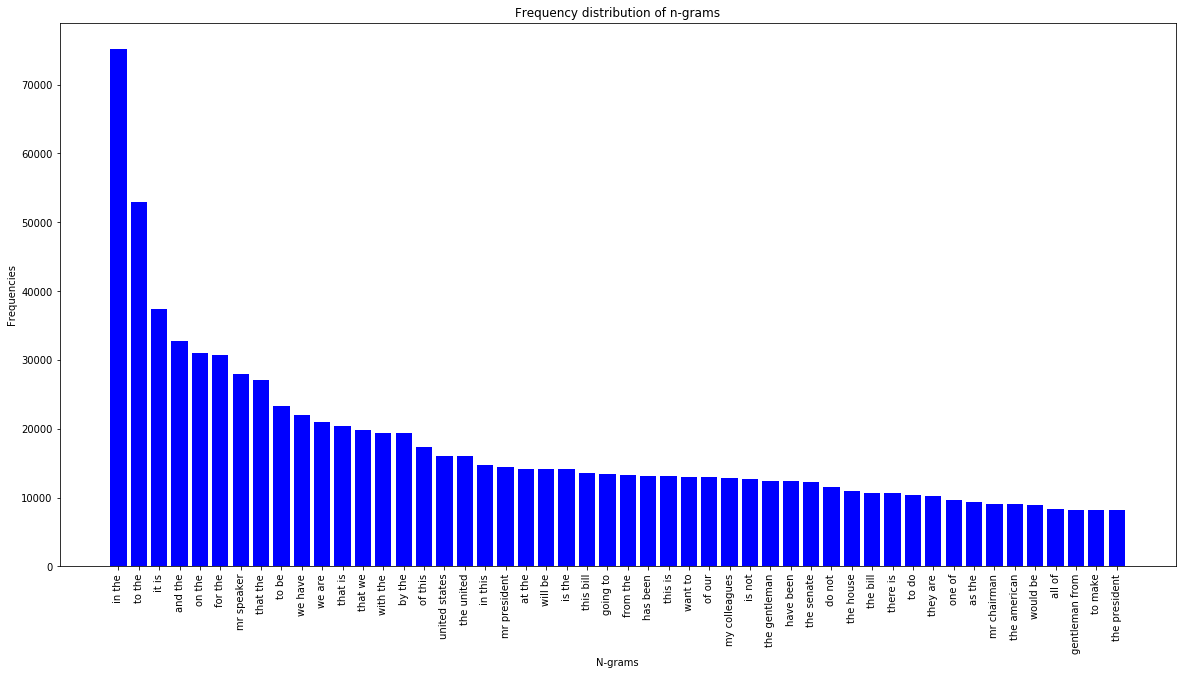

In [28]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(2,2))

['the united states', 'the gentleman from', 'one of the', 'would like to', 'my colleagues to', 'are going to', 'the american people', 'of the united', 'mr speaker rise', 'the department of', 'be able to', 'member of the', 'as well as', 'the committee on', 'urge my colleagues', 'the senator from', 'in the united', 'ask unanimous consent', 'it is not', 'that we have', 'we need to', 'chairman of the', 'we are going', 'in order to', 'the federal government', 'in support of', 'is going to', 'in this country', 'unanimous consent that', 'there is no', 'rise today to', 'that we are', 'speaker rise today', 'the fact that', 'percent of the', 'members of the', 'the people of', 'part of the', 'going to be', 'some of the', 'of the house', 'we do not', 'the state of', 'of the senate', 'thank the gentleman', 'men and women', 'house of representatives', 'we have to', 'that is the', 'all of the']


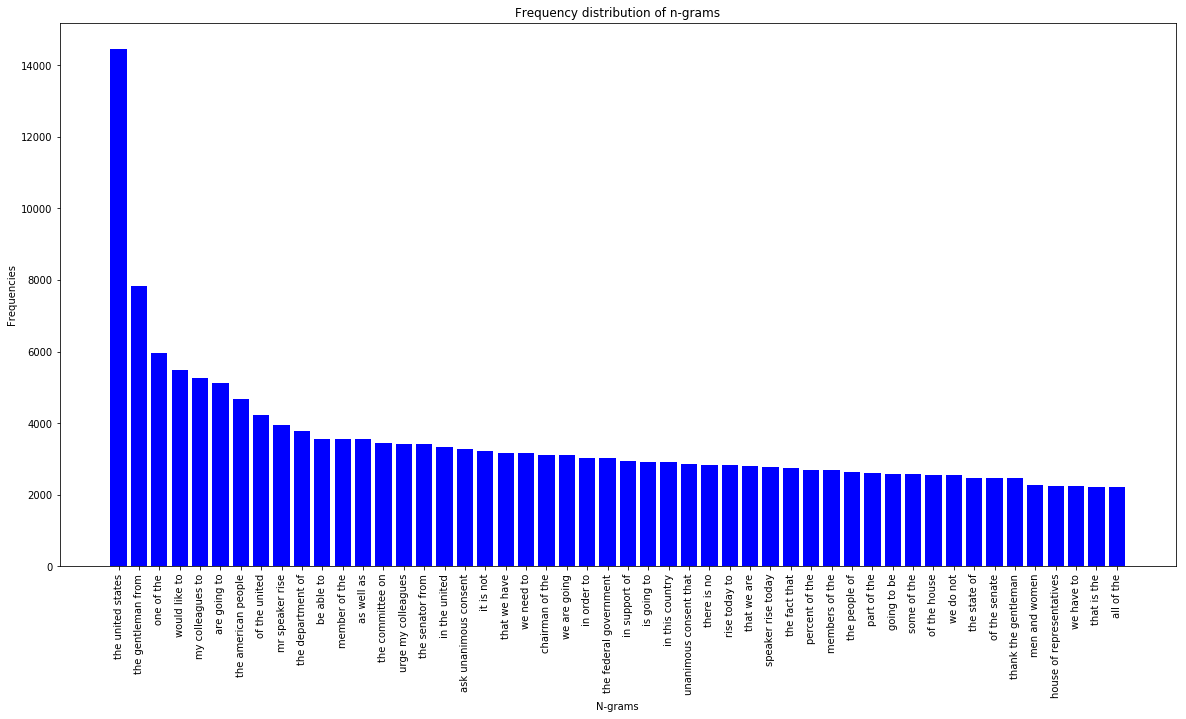

In [29]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(3,3))

In [30]:
congress = set([str(i) for i in range(97,115)])

In [31]:
reload(explore_data)
explore_data.ngrams_by_category(train, train_ids, descr, congress, 'Congress', p=0.3, top_n=5)


For Congress 111 top 5 (3, 3) ngrams are:
the united states
one of the
the american people
my colleagues to
are going to
--------------------

For Congress 102 top 5 (3, 3) ngrams are:
the united states
the gentleman from
would like to
ask unanimous consent
unanimous consent that
--------------------

For Congress 103 top 5 (3, 3) ngrams are:
the united states
the gentleman from
would like to
are going to
the senator from
--------------------

For Congress 107 top 5 (3, 3) ngrams are:
the united states
the gentleman from
one of the
my colleagues to
are going to
--------------------

For Congress 108 top 5 (3, 3) ngrams are:
the united states
the gentleman from
mr speaker rise
one of the
my colleagues to
--------------------

For Congress 101 top 5 (3, 3) ngrams are:
the united states
the gentleman from
ask unanimous consent
unanimous consent that
would like to
--------------------

For Congress 112 top 5 (3, 3) ngrams are:
the united states
the american people
my colleagues to
mr spea

In [33]:
explore_data.ngrams_by_category(train, train_ids, descr, {'D','R'}, 'Party', p=0.3, top_n=10)


For Party D top 10 (3, 3) ngrams are:
the united states
the gentleman from
one of the
my colleagues to
would like to
mr speaker rise
the american people
of the united
are going to
the department of
--------------------

For Party R top 10 (3, 3) ngrams are:
the united states
the gentleman from
are going to
would like to
one of the
the senator from
the american people
of the united
my colleagues to
the federal government
--------------------


In [65]:
del all_speeches, all_speech_ids, descr

## N-gram model

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

### Pre-processing

In [34]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Minimum corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

# Maximum proportion of corpus containing a word above which a token will be discarded.
# Helps eliminate stop words
MAX_DOCUMENT_FREQUENCY = 0.7

# Limit on the number of features. We use the top 20K features.
TOP_K = 10000

# Output number of top/bottom scoring ngrams
TOP_N = 5

vec_params = {
    'ngram_range': NGRAM_RANGE,
    'min_df': MIN_DOCUMENT_FREQUENCY,
    'max_df': MAX_DOCUMENT_FREQUENCY,
    'top_k': TOP_K,
    'top_n': TOP_N
}

In [35]:
reload(preprocess_data)
train_vec, val_vec, test_vec = preprocess_data.ngram_vectorize(train, train_target, val, test, **vec_params)

Total vocabulary size: 956582
Number of stop words 6674085

Top 5 ngrams by differentiating score:
mr president 	 5228.3
speaker 	 4995.2
senator 	 4975.4
mr speaker 	 4017.0
president 	 3534.9

Bottom 5 ngrams by differentiating score:
member were 	 0.0
extent practicable 	 0.0
openly admit 	 0.0
and wirth 	 0.0
people ranging 	 0.0


In [36]:
len(train), len(val), len(test)

(188520, 62840, 62840)

In [37]:
train_vec.shape, val_vec.shape, test_vec.shape

((188520, 10000), (62840, 10000), (62840, 10000))

### Saving processed files

In [38]:
vecdata_path = main_dir+'Classification/data/vectorized/ethnicity'

In [41]:
scipy.sparse.save_npz(os.path.join(vecdata_path, 'train_vec.npz'), train_vec)
scipy.sparse.save_npz(os.path.join(vecdata_path, 'val_vec.npz'), val_vec)
scipy.sparse.save_npz(os.path.join(vecdata_path, 'test_vec.npz'), test_vec)

In [48]:
train_vec = scipy.sparse.load_npz(os.path.join(vecdata_path, 'train_vec.npz'))
val_vec = scipy.sparse.load_npz(os.path.join(vecdata_path, 'val_vec.npz'))
test_vec = scipy.sparse.load_npz(os.path.join(vecdata_path, 'test_vec.npz'))

In [46]:
train_vec.shape, val_vec.shape, test_vec.shape

((188520, 10000), (62840, 10000), (62840, 10000))

In [43]:
outdata_path = main_dir+'Classification/data/splits/ethnicity'

In [44]:
with open(os.path.join(outdata_path, 'train_list'), 'wb') as fp:
    pickle.dump(train, fp)
with open(os.path.join(outdata_path, 'train_ids'), 'wb') as fp:
    pickle.dump(train_ids, fp)
with open(os.path.join(outdata_path, 'train_target'), 'wb') as fp:
    pickle.dump(train_target, fp)
with open(os.path.join(outdata_path, 'val_list'), 'wb') as fp:
    pickle.dump(val, fp)
with open(os.path.join(outdata_path, 'val_ids'), 'wb') as fp:
    pickle.dump(val_ids, fp)
with open(os.path.join(outdata_path, 'val_target'), 'wb') as fp:
    pickle.dump(val_target, fp)
with open(os.path.join(outdata_path, 'test_list'), 'wb') as fp:
    pickle.dump(test, fp)
with open(os.path.join(outdata_path, 'test_ids'), 'wb') as fp:
    pickle.dump(test_ids, fp)
with open(os.path.join(outdata_path, 'test_target'), 'wb') as fp:
    pickle.dump(test_target, fp)

In [45]:
sum(train_target), sum(val_target), sum(test_target)

(94260, 31420, 31420)

In [53]:
with open(os.path.join(outdata_path, 'train_list'), 'rb') as fp:
    train = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_ids'), 'rb') as fp:
    train_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_target'), 'rb') as fp:
    train_target = pickle.load(fp)

In [54]:
with open(os.path.join(outdata_path, 'val_list'), 'rb') as fp:
    val = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)

In [55]:
sum(val_target), len(val_target)

(4713, 9426)

In [56]:
with open(os.path.join(outdata_path, 'test_list'), 'rb') as fp:
    test = pickle.load(fp)
with open(os.path.join(outdata_path, 'test_ids'), 'rb') as fp:
    test_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'test_target'), 'rb') as fp:
    test_target = pickle.load(fp)

In [57]:
sum(train_target), sum(val_target), sum(test_target)

(14140, 4713, 4714)

### Model: Multi-Layer Perceptron (Vanilla NN)

In [47]:
logs_base_dir = main_dir + 'Classification/logs/Ethnicity'

In [48]:
ngram_model_params = {
    'model': 'mlp',
    'learning_rate': 0.001,
    'epochs': 1000,
    'batch_size': 128,
    'layers': 2,
    'units': 64,
    'dropout_rate': 0.2
}

In [49]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), logs_base_dir, **ngram_model_params)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Train on 188520 samples, validate on 62840 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
 - 38s - loss: 0.5533 - acc: 0.7161 - val_loss: 0.5176 - val_acc: 0.7400
Epoch 2/1000
 - 36s - loss: 0.5091 - acc: 0.7433 - val_loss: 0.5087 - val_acc: 0.7448
Epoch 3/1000
 - 36s - loss: 0.4955 - acc: 0.7512 - val_loss: 0.5054 - val_acc: 0.7469
Epoch 4/1000
 - 36s - loss: 0.4849 - acc: 0.7583 - val_loss: 0.5044 - val_acc: 0.7489
Epoch 5/1000
 - 36s - loss: 0.4737 - acc: 0.7666 - val_loss: 0.5007 - val_acc: 0.7517
Epoch 6/1000
 - 37s - loss: 0.4636 - acc: 0.7738 - val_loss: 0.4979 - val_acc: 0.7544
Epoch 7/1000
 - 37s - loss: 0.4522 - acc: 0.7821 - val_loss: 0.4982 - val_acc: 0.7555
Epoch 8/1000
 - 36s - loss: 0.4398 - acc: 0.7900 - val_loss: 0.4982 - val_acc: 0.7562
Validation accuracy: 0.756

In [53]:
probs_path = main_dir+'Classification/data/probs/ethnicity/'

In [60]:
np.save(probs_path+'val_pred_probs_mlp_ngram', val_pred_probs, allow_pickle=True, fix_imports=True)

In [56]:
val_pred_probs = np.load(probs_path+'val_pred_probs_mlp_ngram.npy', allow_pickle=True, fix_imports=True)

## Model evaluation

In [61]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target)

47518

Confusion matrix, without normalization
[[24863  6557]
 [ 8765 22655]]
             precision    recall  f1-score   support

      White       0.74      0.79      0.76     31420
  Non-White       0.78      0.72      0.75     31420

avg / total       0.76      0.76      0.76     62840



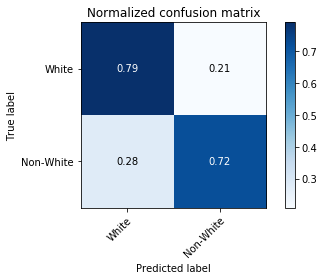

In [62]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['White', 'Non-White']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

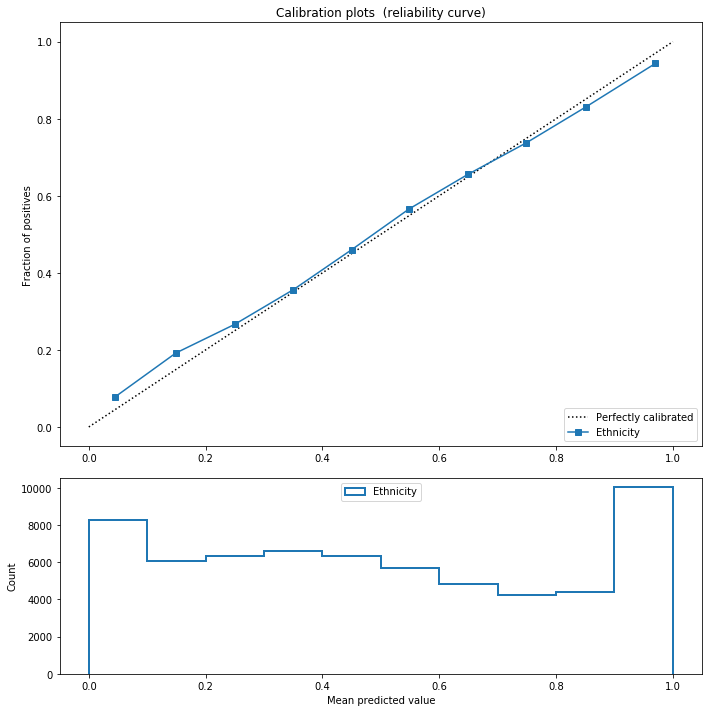

In [63]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Ethnicity')

In [67]:
del train, train_ids, train_pred_probs, train_target, train_vec

In [68]:
descr_df = pd.read_csv(main_dir+'data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.shape

/home/yulia/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(62840, 16)

In [69]:
descr_df.head()

,date,char_count,word_count,speakerid,Party,Congress,Chamber,State,Ethnicity,Age,Age_lt_med,NonWhite,Female,speaker,Full Name,match
speech_id,,,,,,,,,,,,,,,,
1010243717,19901025,870,166,101110870.0,D,101,H,TX,B,49.0,1.0,1.0,0.0,Mr. WASHINGTON,"WASHINGTON, CRAIG",exact
1120097305,20120416,1186,197,112116570.0,R,112,H,OH,AAPIA,54.0,1.0,1.0,0.0,Mr. AUSTRIA,"AUSTRIA, STEVE",fuzzy
1020183502,19920630,257,40,102111850.0,D,102,H,TX,H,76.0,0.0,1.0,0.0,Mr. GONZALEZ,"GONZALEZ, HENRY",exact
1080187463,20041001,2689,420,108115260.0,D,108,H,MD,B,53.0,1.0,1.0,0.0,Mr. WYNN,"WYNN, ALBERT",fuzzy
1090010764,20050309,7723,1156,109116411.0,D,109,S,HI,AAPIA,82.0,0.0,1.0,0.0,Mr. AKAKA,"AKAKA, DANIEL",exact


In [70]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs, 
                                   val_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.175939            0.5  58.427562  0.690738   0.694876    376.978469


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.44,0.43,0.99,0.78,0.68,1.07
0.6,0.91,1.02,0.99,1.01,1.16,0.80
1.0,1.70,1.65,1.01,1.25,1.28,1.02


In [71]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
the cbc 	 7968.3
cbc 	 7448.9
cbc budget 	 4037.6
cbc alternative 	 2724.9
congressional black 	 2052.5
black caucus 	 2031.1
designated 1992 	 1525.0
president designated 	 1525.0
law pays 	 1525.0
102188 res 	 1435.5


bin,1,2,3,4
black caucus,8.0,8.0,1065.0,178.0
cbc,0.0,0.0,185.0,241.0
cbc alternative,0.0,0.0,9.0,36.0
cbc budget,0.0,0.0,40.0,91.0
congressional black,0.0,8.0,994.0,168.0
designated 1992,0.0,0.0,4.0,10.0
law 102188,0.0,0.0,3.0,9.0
law pays,0.0,0.0,4.0,10.0
president designated,0.0,0.0,4.0,10.0
the cbc,0.0,0.0,134.0,219.0


In [72]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr_df)


True positive (Predicted prob: 1.00):

date                   20000721
char_count                 2805
word_count                  450
speakerid           1.06121e+08
Party                         D
Congress                    106
Chamber                       H
State                        CA
Ethnicity                     H
Age                          64
Age_lt_med                    0
NonWhite                      1
Female                        1
speaker         Mrs. NAPOLITANO
Full Name     NAPOLITANO, GRACE
match                     fuzzy
Name: 1060176127, dtype: object

 Mr. Speaker. today I praise Mr. Gustavo "Gus" Velasco. a distinguished public servant in my 34th Congressional District in California. He is retiring as Assistant City Manager for Community Services of Santa Fe Springs. California after an illustrious career of 39 years of service. Gus Velascos steadfast commitment to .public service has made him a recognized leader and admirable member of the community. He is 

#### Run the following test on a random subset of the validation sample

In [73]:
np.random.seed(100)
val_random = np.random.choice(a=[0,1], size=len(val_target), p = [0.9,0.1])
val_random.sum()/val_random.shape[0]

0.10103437301082113

In [74]:
val_sample, val_ids_sample, val_pred_probs_sample = [], [], []
for i in range(len(val_ids)):
    if val_random[i] == 1:
        val_sample.append(val[i])
        val_ids_sample.append(val_ids[i])
        val_pred_probs_sample.append(val_pred_probs[i])
len(val_sample), len(val_ids_sample), len(val_pred_probs_sample)

(6349, 6349, 6349)

In [75]:
reload(explore_data)
explore_data.ngrams_by_bin(val_sample, val_pred_probs_sample)


In 0.4 bin top 10 ngrams:

the united states
the senator from
are going to
the gentleman from
one of the
would like to
we are going
of the united
the american people
is going to
--------------------

In 0.6 bin top 10 ngrams:

the united states
the gentleman from
my colleagues to
would like to
one of the
urge my colleagues
mr speaker rise
of the united
urge my colleagues to
the committee on
--------------------

In 1.0 bin top 10 ngrams:

the united states
the gentleman from
my colleagues to
mr speaker rise
one of the
would like to
the american people
speaker rise today
urge my colleagues
of the united
--------------------
